# Redo Marks fitness pred

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


Test set size = 1401


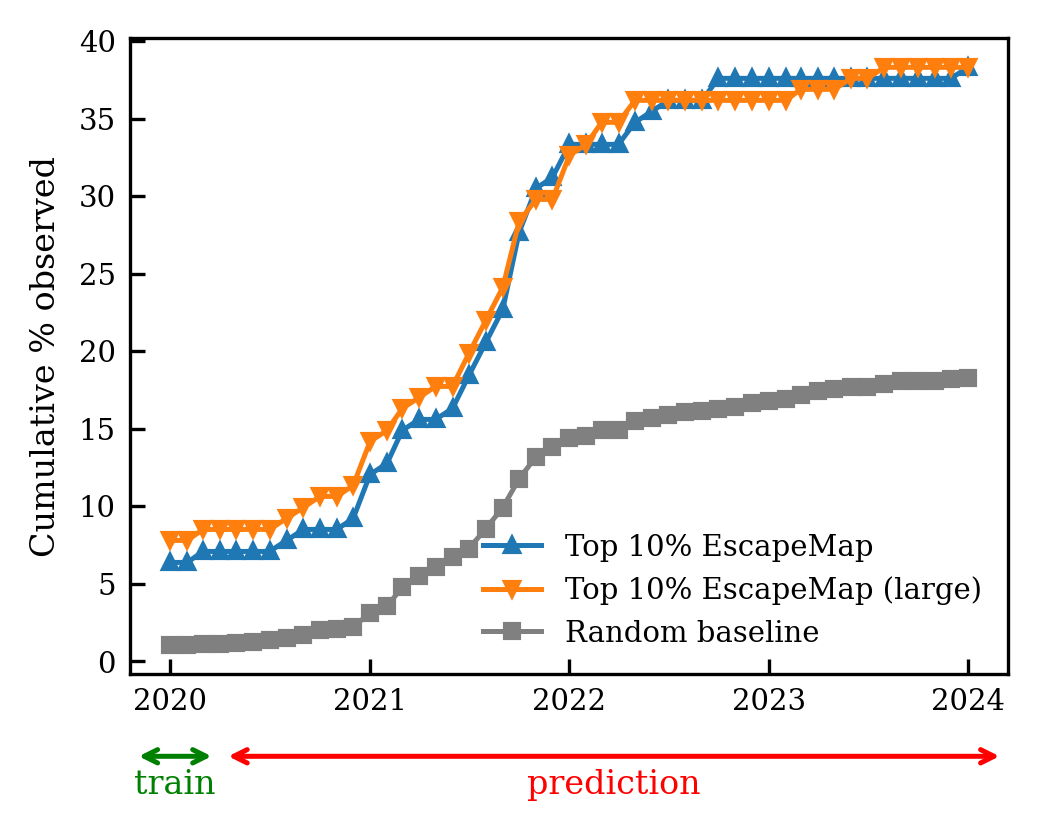

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd

train_date = pd.Timestamp("2020-04-01")  # or any date-like
tag = train_date.strftime("%Y-%m")       # AAAA-MM

em_path = f"results_periods_smaller_training/scores_sigmoid_diff_allab_{tag}.csv"
em_large_path = f"results_periods_smaller_training_large/scores_sigmoid_diff_allab_{tag}.csv"

df_em = pd.read_csv(em_path)
df_em_large = pd.read_csv(em_large_path)

# --- Load base ---
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")

# handle possible column name change: 'counts_100' vs 'count'
count_col = 'counts_100' if 'counts_100' in df_base.columns else ('count' if 'count' in df_base.columns else None)
if count_col is not None:
    df_base.loc[df_base[count_col] < 100, 'first_seen_100'] = pd.NaT  # mask low-count dates

th = 90  # percentile threshold

# ---------- Prepare frames ----------
df = df_base.copy()

# load EscapeMap scores


col_em = "score" if "score" in df_em.columns else "scores"
col_em_large = "score" if "score" in df_em_large.columns else "scores"

df["escapemap"] = df_em[col_em].values
df["escapemap_large"] = df_em_large[col_em_large].values

print(f"Test set size = {len(df)}")

# thresholds
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)
thr_em_large = np.nanpercentile(df["escapemap_large"], th)

# subsets (top 100-th % for each scoring scheme)
top_eve = df[df["evescape"]        >= thr_eve].copy()
top_em  = df[df["escapemap"]       >= thr_em].copy()
top_em_large = df[df["escapemap_large"] >= thr_em_large].copy()

# drop NaT
with_seen_eve = top_eve.dropna(subset=["first_seen_100"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen_100"]).copy()
with_seen_em_large = top_em_large.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_eve, with_seen_em, with_seen_em_large):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
tot_eve, tot_em, tot_em_large = len(top_eve), len(top_em), len(top_em_large)
avg_eve = cum_frac(with_seen_eve,       tot_eve,       global_months)
avg_em  = cum_frac(with_seen_em,        tot_em,        global_months)
avg_em_large = cum_frac(with_seen_em_large, tot_em_large, global_months)

# random: percentage of total mutations that appeared in pandemic
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot (single curves, no seed averaging) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))

# ax.plot(global_months, avg_eve, marker="o", label=f"Top {100-th}% EVEscape")
ax.plot(global_months, avg_em,  marker="^", label=f"Top {100-th}% EscapeMap")
ax.plot(global_months, avg_em_large, marker="v", label=f"Top {100-th}% EscapeMap (large)")
ax.plot(global_months, avg_rnd, marker="s", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows placed lower ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = train_date

y = -0.13
xf = ax.get_xaxis_transform()  # data x, axes-fraction y

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)


plt.show()


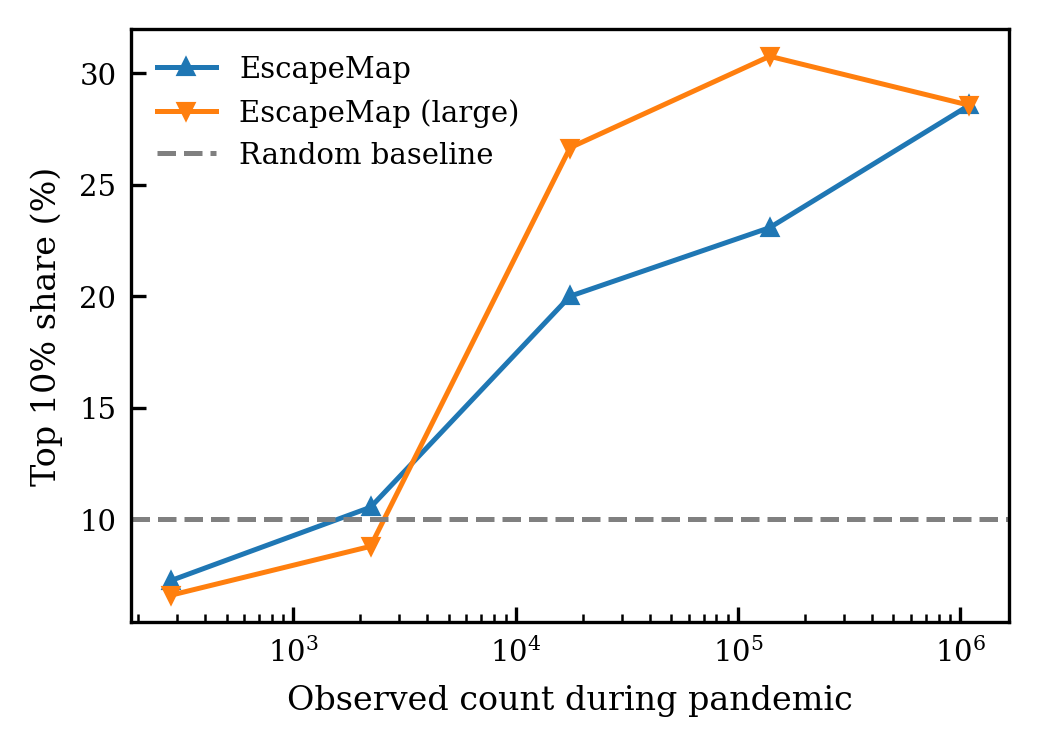

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ----------------- Params -----------------
NB_EDGES = 6           # number of log-space edges => NB_EDGES-1 bins
th = 90                # percentile threshold (top 5%)


# ----------------- Load & restrict to RBD -----------------
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")

# Load EscapeMap scores: small and large

col_em = "score" if "score" in df_em.columns else "scores"
col_em_large = "score" if "score" in df_em_large.columns else "scores"
df_base["escapemap"] = df_em[col_em].values
df_base["escapemap_large"] = df_em_large[col_em_large].values

# Test period mask
df_base['test'] = np.where(df_base['first_seen_100'] > pd.to_datetime('2020-03-01'), 1, 0)
df_base = df_base[df_base['test'] == 1].copy()

# Parse first_seen and pandemic window
df_base["first_seen_dt"] = pd.to_datetime(df_base["first_seen_100"], format="%Y-%m", errors="coerce")
pandemic_start = pd.Timestamp("2020-01-01")
pandemic_end   = pd.Timestamp("2026-01-01")  # exclusive
obs = df_base[(df_base["first_seen_dt"] >= pandemic_start) & (df_base["first_seen_dt"] < pandemic_end)].copy()

# ----------------- Build log-spaced frequency bins -----------------
freq_col = "count" if "count" in obs.columns else ("counts_100" if "counts_100" in obs.columns else None)
if freq_col is None:
    raise ValueError("No frequency column found: expected 'count' or 'counts_100'.")

freq = pd.to_numeric(obs[freq_col], errors="coerce").fillna(0).astype(float)
freq_clip = np.clip(freq.values, 1.0, None)   # clip zeros to 1 for binning

lo, hi = float(np.nanmin(freq_clip)), float(np.nanmax(freq_clip))
if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
    raise ValueError("Frequency range invalid; cannot create log bins.")

edges_log = np.linspace(np.log10(lo), np.log10(hi), NB_EDGES)
edges = 10.0 ** edges_log
midpoints = np.sqrt(edges[:-1] * edges[1:])  # geometric mean per bin

# Precompute bin masks for obs
bin_masks = []
for i in range(NB_EDGES - 1):
    left, right = edges[i], edges[i+1]
    if i < NB_EDGES - 2:
        bin_mask = (freq_clip >= left) & (freq_clip < right)
    else:
        bin_mask = (freq_clip >= left) & (freq_clip <= right)
    bin_masks.append(bin_mask)

# ----------------- Helper -----------------
def share_top_decile(values, threshold, base_mask):
    n = int(base_mask.sum())
    if n == 0:
        return np.nan
    return 100.0 * np.sum(values[base_mask] >= threshold) / n

# ----------------- Thresholds on FULL RBD set -----------------
thr_eve_global = np.nanpercentile(df_base["evescape"], th)
thr_em_global  = np.nanpercentile(df_base["escapemap"], th)
thr_em_large_global  = np.nanpercentile(df_base["escapemap_large"], th)

# Values aligned to obs
eve_vals_obs = df_base.loc[obs.index, "evescape"].values
em_vals_obs  = df_base.loc[obs.index, "escapemap"].values
em_large_vals_obs  = df_base.loc[obs.index, "escapemap_large"].values

# ----------------- Per-bin shares -----------------
eve_curve = []
em_curve  = []
em_large_curve  = []
for bin_mask in bin_masks:
    eve_curve.append(share_top_decile(eve_vals_obs, thr_eve_global, bin_mask))
    em_curve.append(share_top_decile(em_vals_obs,  thr_em_global,  bin_mask))
    em_large_curve.append(share_top_decile(em_large_vals_obs,  thr_em_large_global,  bin_mask))

eve_curve = np.array(eve_curve, dtype=float)
em_curve  = np.array(em_curve,  dtype=float)
em_large_curve  = np.array(em_large_curve,  dtype=float)

# ----------------- Random baseline -----------------
random_baseline = 100 - th  # e.g., 5 for top-5%

# ----------------- Plot -----------------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))
x = midpoints

# ax.plot(x, eve_curve, marker="o", label="EVEscape")
ax.plot(x, em_curve,  marker="^", label="EscapeMap")
ax.plot(x, em_large_curve,  marker="v", label="EscapeMap (large)")
ax.axhline(random_baseline, linestyle="--", label="Random baseline", color="grey")

ax.set_xscale("log")
ax.set_xlabel("Observed count during pandemic")
ax.set_ylabel(f"Top {100 - th}% share (%)")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()


# Plot variant fitness

In [71]:
import pandas as pd
import torch
from escape_map_torch import EscapeMapTorch
from escape_map import EscapeMap, load_escape_map_from_csv, score_seq_batch
 

# Example usage:
train_date = pd.Timestamp("2021-10-01")  # or any date-like
tag = train_date.strftime("%Y-%m")       # AAAA-MM

em_large_path = f"results_periods_smaller_training_large/params_sigmoid_diff_allab_{tag}.csv"

model = load_escape_map_from_csv(em_large_path)
FASTA = "../seq_data/ns_mutated_spike.fasta"  # headers: >{date}|{region}|{pango}
model.raw_beta


-3.263769874314359

   period_key      pango date_parsed      score
0     2019-H2          B  2019-12-23   3.094187
1     2020-H1        B.1  2020-01-28   3.094187
2     2020-H2      B.1.1  2020-07-01   3.094187
3     2021-H1    B.1.1.7  2021-01-01   3.492099
4     2021-H2  B.1.617.2  2021-07-01   7.241917
5     2022-H1       BA.2  2022-01-02  15.613718
6     2022-H2     BA.5.2  2022-07-01  16.911508
7     2023-H1    XBB.1.5  2023-01-03  19.460066
8     2023-H2   EG.5.1.1  2023-07-01  19.626995
9     2024-H1       JN.1  2024-01-01  18.758580
10    2024-H2   KP.3.1.1  2024-07-01  18.195505
11    2025-H1   LP.8.1.1  2025-01-01  18.687215
12    2025-H2        XFG  2025-07-01  17.550008


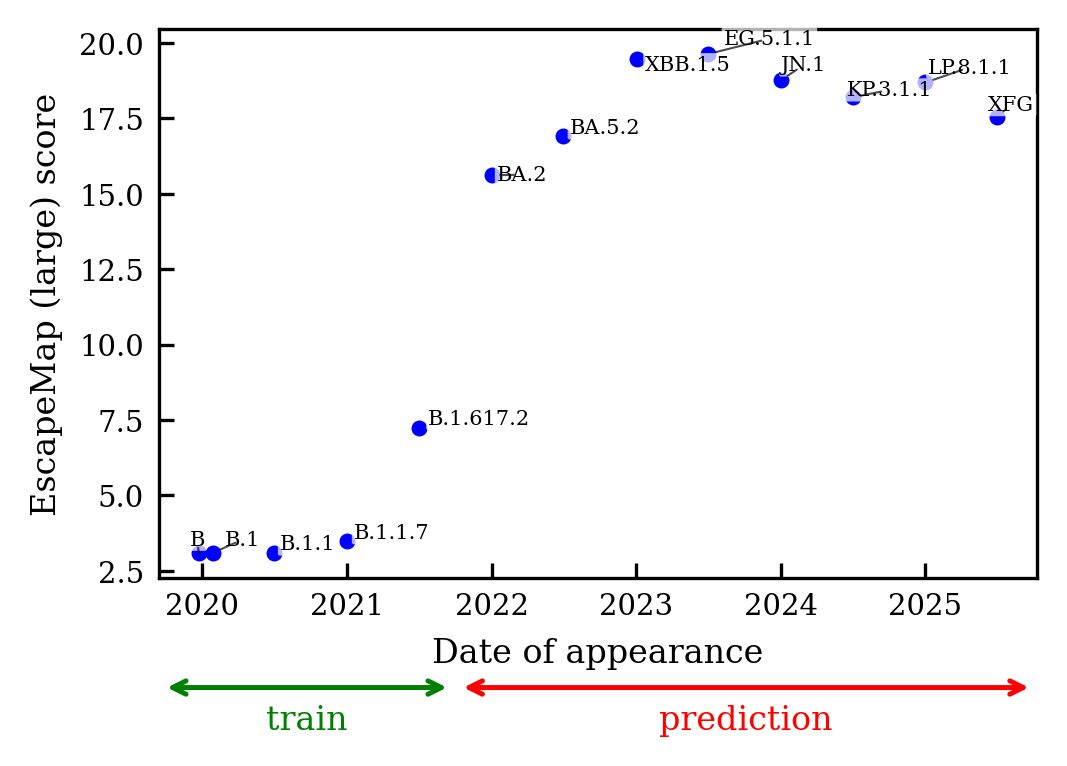

In [72]:
import re
import numpy as np
import torch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

# --- helpers ---
def read_fasta_headers_and_seqs(path):
    headers, seqs = [], []
    with open(path, "r") as f:
        cur = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if cur:
                    seqs.append("".join(cur)); cur = []
                headers.append(line[1:])
            else:
                cur.append(line)
        if cur:
            seqs.append("".join(cur))
    return headers, seqs

def parse_header(h):
    # >date|region|pango
    parts = h.split("|")
    date  = parts[0] if len(parts) > 0 else ""
    pango = parts[2] if len(parts) > 2 else ""
    return date, pango

# --- 1) read fasta and numeric sequences in the same order ---
headers, seqs_str = read_fasta_headers_and_seqs(FASTA)
VOCS_NUM = Proteins_utils.load_FASTA(FASTA, drop_duplicates=False)  # numeric encoding
assert len(headers) == len(seqs_str) == len(VOCS_NUM), "FASTA order mismatch"

df = pd.DataFrame({
    "idx": np.arange(len(headers)),
    "header": headers,
    "seq_str": seqs_str
})
df[["date", "pango"]] = df["header"].apply(lambda h: pd.Series(parse_header(h)))
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date_parsed"]).reset_index(drop=True)

# --- half-year bins ---
df["year"] = df["date_parsed"].dt.year
df["half"] = np.where(df["date_parsed"].dt.month <= 6, 1, 2)
df["period_key"] = df["year"].astype(str) + "-H" + df["half"].astype(str)
# ensure chronological processing of bins
period_order = (
    df.groupby("period_key", as_index=False)["date_parsed"]
      .min().sort_values("date_parsed")["period_key"].tolist()
)

# --- per-bin representative:
# pick dominant pango if new; else second dominant. Ties by earliest first-seen date.
reps = []
seen_pangos = set()
for key in period_order:
    g = df[df["period_key"] == key]
    if g.empty:
        continue

    # rank pangos by count desc, tie-break by earliest date
    counts = g.groupby("pango").size().rename("cnt")
    first_seen = g.groupby("pango")["date_parsed"].min().rename("first_seen")
    rank = (pd.concat([counts, first_seen], axis=1)
              .sort_values(["cnt", "first_seen"], ascending=[False, True])
              .reset_index())

    # choose pango: dominant if not seen before, else second dominant if available
    if rank.empty:
        continue
    if rank.loc[0, "pango"] not in seen_pangos:
        chosen_pango = rank.loc[0, "pango"]
    elif len(rank) >= 2 and rank.loc[1, "pango"] not in seen_pangos:
        chosen_pango = rank.loc[1, "pango"]
    elif len(rank) >= 3 and rank.loc[2, "pango"] not in seen_pangos:
        chosen_pango = rank.loc[2, "pango"]
    else:
        continue
        

    # within chosen pango pick representative sequence:
    # most frequent sequence, tie-break earliest date
    g_choice = g[g["pango"] == chosen_pango].copy()
    seq_counts = g_choice["seq_str"].value_counts()
    top_seq = seq_counts.idxmax()
    cand = g_choice[g_choice["seq_str"] == top_seq].sort_values("date_parsed", ascending=True).iloc[0]

    reps.append({
        "period_key": key,
        "pango": cand["pango"],
        "date_parsed": cand["date_parsed"],
        "idx": int(cand["idx"]),
        "header": cand["header"]
    })
    # mark as seen for next bins
    seen_pangos.add(chosen_pango)

df_dom = pd.DataFrame(reps).sort_values("date_parsed").reset_index(drop=True)

# --- score only the selected representatives ---
seqs_batch = VOCS_NUM[df_dom["idx"].to_numpy()]
df_dom["score"] = score_seq_batch(model, seqs_batch)

print(df_dom[["period_key", "pango", "date_parsed", "score"]])

# --- plot: one red point per half-year (selected representative) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.0,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))
ax.scatter(df_dom["date_parsed"], df_dom["score"], s=8, c="blue")
import numpy as np
import matplotlib.dates as mdates

# --- after your scatter(...) call ---

labels = []
try:
    from adjustText import adjust_text

    # draw texts first
    for _, r in df_dom.iterrows():
        labels.append(
            ax.text(r["date_parsed"], r["score"], r["pango"],
                    fontsize=5, zorder=3,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7))
        )

    # nudge to avoid overlaps
    adjust_text(
        labels, ax=ax,
        only_move={'points':'y', 'text':'xy'},
        force_text=0.5, force_points=0.3,
        expand_points=(1.2, 1.4), expand_text=(1.1, 1.2),
        arrowprops=dict(arrowstyle='-', lw=0.5, alpha=0.7)
    )

except Exception:
    # --- fallback: deterministic small jitters in points ---
    # order by date to spread offsets
    tmp = df_dom.sort_values("date_parsed").reset_index(drop=True)
    offsets = ((np.arange(len(tmp)) % 7) - 3) * 2  # [-6,-4,-2,0,2,4,6] pt

    for i, r in tmp.iterrows():
        ax.annotate(r["pango"], (r["date_parsed"], r["score"]),
                    xytext=(0, offsets[i]), textcoords="offset points",
                    fontsize=7, zorder=3,
                    bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7))
        
# --- end after scatter(...) ---
import matplotlib.dates as mdates
import pandas as pd

# ensure room for below-axis annotations
plt.subplots_adjust(bottom=0.25)

# bounds
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = train_date

# y position below axis in axes-fraction coords
y = -0.2
xf = ax.get_xaxis_transform()  # x in data coords, y in axes fraction

# green train arrow
ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"))
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.03, "train", color="green", ha="center", va="top",
        transform=xf)

# red prediction arrow
ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"))
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.03, "prediction", color="red", ha="center", va="top",
        transform=xf)


ax.set_xlabel("Date of appearance")
ax.set_ylabel("EscapeMap (large) score")
ax.tick_params(direction="in", which="both", top=False, right=False)
fig.tight_layout(pad=0.5)
plt.show()

# Best mutations on BA.2

In [89]:
BQ='SVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGNEVSQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCG'
len(BQ)#it is actually BA2
BQ_SEQ=Proteins_utils.seq2num(BQ)
# BQ: amino-acid sequence string already defined
# Example:
# BQ = "MFVFLVLLPLVSSQCV..."  # Spike or any protein

AA = "ACDEFGHIKLMNPQRSTVWY"

def wrap60(s):
    return "\n".join(s[i:i+60] for i in range(0, len(s), 60))

def write_single_mutants_fasta(wt_seq, out_path="../seq_data/BQ_single_mutants.fasta", prefix="BQ"):
    n_written = 0
    with open(out_path, "w") as f:
        for i, wt in enumerate(wt_seq, start=1):
            if wt not in AA:
                continue  # skip non-canonical sites
            for alt in AA:
                if alt == wt:
                    continue
                mut = f"{wt}{i}{alt}"
                seq = wt_seq[:i-1] + alt + wt_seq[i:]
                f.write(f">{prefix}_{mut}\n{wrap60(seq)}\n")
                n_written += 1
    print(f"Wrote {n_written} single mutants to {out_path}")

# run
write_single_mutants_fasta(BQ, out_path="../seq_data/BA2_single_mutants.fasta", prefix="BQ")


Wrote 3382 single mutants to ../seq_data/BA2_single_mutants.fasta


In [90]:
seqs_batch=Proteins_utils.load_FASTA("../seq_data/BA2_single_mutants.fasta")
scores_diff=score_seq_batch(model, seqs_batch)+model(BQ_SEQ)
scores_diff

array([-0.57190781, -0.93581085, -0.56943589, ..., -0.74165401,
       -1.0950858 , -0.79590791])

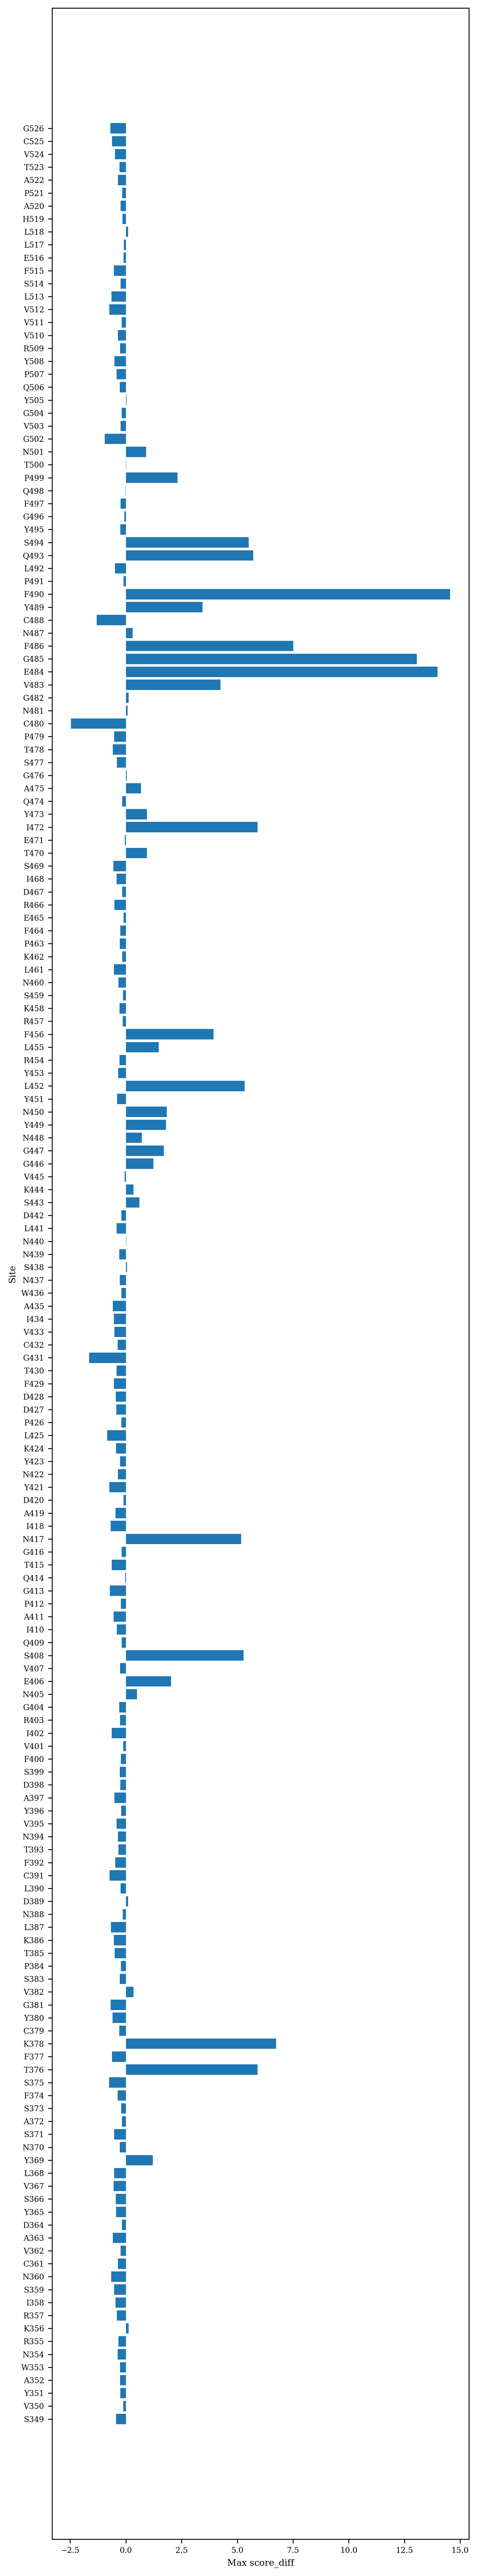

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Inputs you already have:
# BQ: wild-type sequence string
# scores_diff: 1D numpy array with scores for ALL single mutants generated in order:
#   for pos in 1..L, for aa in AA if aa != wt[pos], write mutant

AA = "ACDEFGHIKLMNPQRSTVWY"  # canonical 20 AA

def max_per_site_from_single_mutants(wt_seq, scores, alphabet=AA):
    L = len(wt_seq)
    # how many mutants per site (19 if canonical WT, else 0 because skipped)
    per_site_counts = []
    for i in range(L):
        wt = wt_seq[i]
        if wt in alphabet:
            per_site_counts.append(len(alphabet) - 1)  # exclude WT
        else:
            per_site_counts.append(0)  # no mutants were generated for non-canonical WT

    expected = sum(per_site_counts)
    if scores.shape[0] != expected:
        raise ValueError(f"Length mismatch: got {scores.shape[0]} scores, expected {expected} "
                         f"from sequence length {L} and generation scheme.")

    # slice scores per site and take max
    out_rows = []
    idx = 0
    for i in range(L):
        wt = wt_seq[i]
        k = per_site_counts[i]
        if k == 0:
            idx += 0
            continue
        site_scores = scores[idx:idx+k]
        idx += k
        out_rows.append({"pos": i + 1+348, "wt": wt, "max_score": float(np.max(site_scores))})

    df = pd.DataFrame(out_rows)
    return df

# Compute table
df_max = max_per_site_from_single_mutants(BQ, scores_diff, alphabet=AA)
# Optional: sort by position
df_max = df_max.sort_values("pos").reset_index(drop=True)

# Labels like "A123"
labels = df_max.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1)
values = df_max["max_score"].to_numpy()

# Plot horizontal bars
plt.figure(figsize=(6, max(3, 0.18 * len(df_max))))  # adaptive height
y = np.arange(len(values))
plt.barh(y, values)
plt.yticks(y, labels)
plt.xlabel("Max score_diff")
plt.ylabel("Site")
plt.tight_layout()
plt.show()


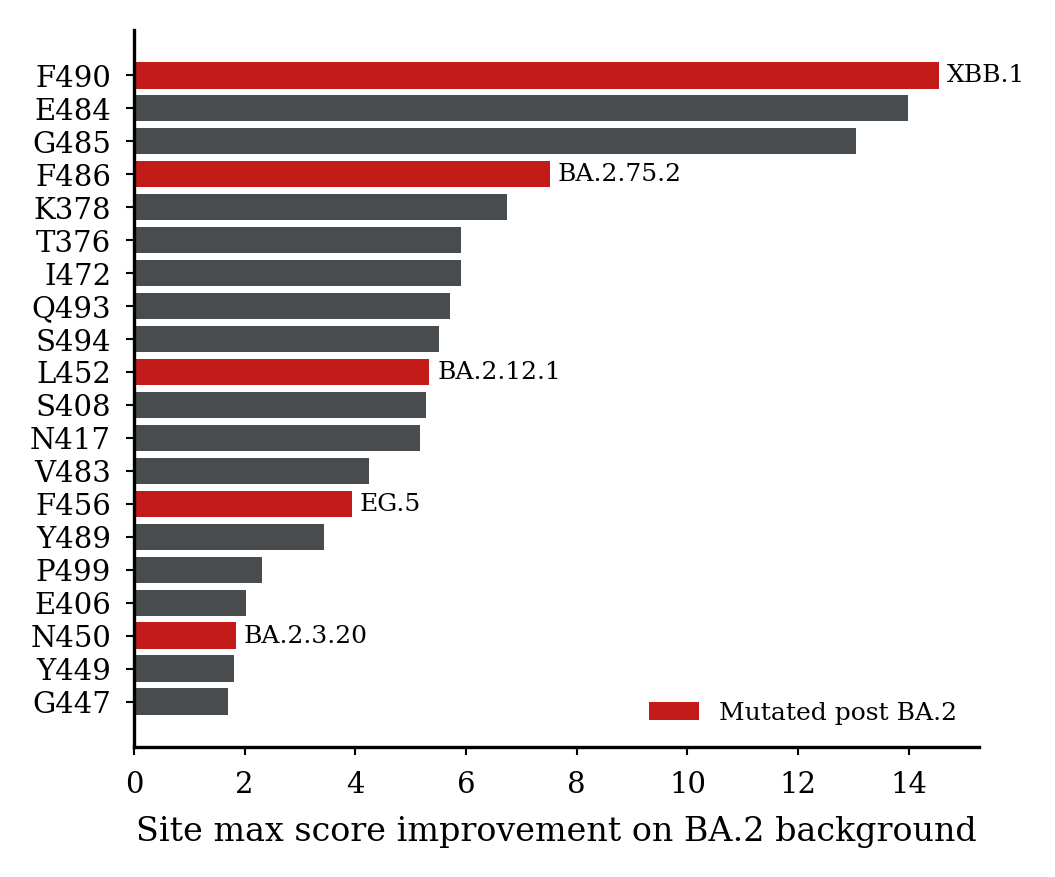

In [95]:
# --- Top 20 by max_score (highest at top) ---
df_top20 = (
    df_max.nlargest(20, "max_score")
          .sort_values("max_score", ascending=True)
          .copy()
)
labels = df_top20.apply(lambda r: f"{r['wt']}{int(r['pos'])}", axis=1).to_numpy()
vals   = df_top20["max_score"].to_numpy()
sites  = df_top20["pos"].astype(int).to_numpy()

ba2_new_mut = {346, 356, 368, 403, 444, 445, 446, 450, 452, 455, 456, 460, 481, 486, 490}

# Mapping of key BA.2 sublineage mutations to appearance variants
site_to_variant = {
    490: "XBB.1",
    486: "BA.2.75.2",
    452: "BA.2.12.1",
    456: "EG.5",
    450: "BA.2.3.20",
    # Add others if needed
}

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors: blue default, orange highlight
base_color = "#494c4e"   # Matplotlib default blue
highlight  = "#C31A1A"   # muted orange
colors = [highlight if s in ba2_new_mut else base_color for s in sites]

# Small PRL-style figure (~1 column width, 8.6 cm)
fig, ax = plt.subplots(figsize=(3.4, 2.8))

y = np.arange(len(vals))
bars = ax.barh(y, vals, color=colors, edgecolor="none")

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Site max score improvement on BA.2 background", fontsize=8)

# Clean frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis="both", which="both", length=2, width=0.5, labelsize=7)

# Annotate variant names for BA.2 sublineage mutations only
xmax = float(vals.max()) if len(vals) else 1.0
pad = 0.01 * xmax
for yi, (bar, s) in enumerate(zip(bars, sites)):
    if s in ba2_new_mut:
        variant = site_to_variant.get(int(s), "")
        if variant:
            ax.text(bar.get_width() + pad, yi, variant,
                    va="center", ha="left", fontsize=6)

# Legend
handles = [
    Patch(facecolor=highlight, edgecolor="none",
          label="Mutated post BA.2"),
]
ax.legend(handles=handles, frameon=False, fontsize=6, loc="lower right")

plt.tight_layout(pad=0.3)
plt.show()
